In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as tf
import torchvision.transforms.functional as ttf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from lime import lime_image
from skimage.segmentation import mark_boundaries

In [2]:
# Path Variables
axPath = "Ax_model_states.pth"
cnnPath = "cnn_model_states.pth"
ensemblePath = "Ensemble_model_states.pth"
metadataPath = "./Garbage_data/Garbage_Dataset_Classification/metadata.csv"
imagePath = "./Garbage_data/Garbage_Dataset_Classification/images"

In [4]:
# Setting variables
seed         = 67
split_seed   = 13

nLineSamples = 1000   
nFeatures    = 6  

In [5]:
# Seeding
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [6]:
# Device Setup
if torch.backends.mps.is_available():   
    device = torch.device("mps")

elif torch.cuda.is_available():
    device = torch.device("cuda")   

else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cpu


In [7]:
# Load Dataset Metadata
metadata_df = pd.read_csv(metadataPath)
print("Metadata Loaded.\n")

Metadata Loaded.



In [8]:
# Training/Validation Split
metadata_train_df, metadata_val_df = train_test_split(metadata_df, random_state=split_seed, stratify=metadata_df["label"].values)
print("Train/Eval Split performed.\n")

Train/Eval Split performed.



In [9]:
# Load Labels and Class Number
labels = sorted(metadata_df["label"].unique())
label_to_idx = {label: idx for idx, label in enumerate(labels)}
idx_to_label = {v: k for k, v in label_to_idx.items()}

num_classes = len(labels)
print(f"Labels: {labels} \n Classes: {num_classes}")

Labels: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'] 
 Classes: 6


In [10]:
# CNN_Train Function Recreation to Avoid Training Loop.
def get_image_path(row: pd.Series) -> str:
    return os.path.join(imagePath, row["label"], row["filename"])

class CustomCNN(nn.Module):
    def __init__(self, num_classes: int = 6):
        super(CustomCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> 128x128
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> 64x64
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> 32x32
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 32 * 32, 256),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

class AxNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0):
        super(AxNet, self).__init__()
        self.num_classes = num_classes

        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # 63->31

            nn.Conv2d(96, 256, kernel_size=5, padding=2, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # 31->15

            nn.Conv2d(256, 384, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),  # 15-> 15

            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),  # 15-> 15

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # 15-> 7
        )

        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(256 * 7 * 7, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(64, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


class EnsembleCNN(nn.Module):
    def __init__(self, model1, model2):
        super(EnsembleCNN, self).__init__()
        self.model1 = model1
        self.model2 = model2

    def forward(self, x):
        output1 = self.model1(x)
        output2 = self.model2(x)
        ensemble_output = (output1 + output2) / 2  # Averaging logits
        return ensemble_output

In [11]:
# Training Normalization 
mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
std  = torch.tensor([0.2470, 0.2435, 0.2616]).view(3, 1, 1)

In [12]:
# Converts images to a normalized tensor shape: (3, 256, 256) from (256, 256, 3)
def imagePreprocess(img_rgb):

    # Convert to float [0,1]
    img = img_rgb.astype(np.float32) / 255.0

    # HWC -> CHW
    tensor = torch.from_numpy(img).permute(2, 0, 1)

    # Resize to 256x256 to match training input size
    tensor = ttf.resize(tensor, [256, 256], antialias=True)

    # Normalize using training mean/std
    tensor = (tensor - mean) / std

    return tensor

In [13]:
# Determines Classification Probabilities 
def limePredict(images, model):
    model.eval()
    batch_tensors = []

    for img in images:
        t = imagePreprocess(img)
        batch_tensors.append(t)

    batch = torch.stack(batch_tensors).to(device)

    with torch.no_grad():
        logits = model(batch)
        probs = tf.softmax(logits, dim=1)

    return probs.cpu().numpy()

In [14]:
# LIME Explanation: Evaluates Model based on a Single Image
def limeExplain(val_index, model, model_name):
    
    # Load Validation
    row             = metadata_val_df.iloc[val_index]
    true_label_name = row["label"]
    img_path        = get_image_path(row)

    if not os.path.exists(img_path):
        raise FileNotFoundError(f"Image not found at path: {img_path}")

    # BGR -> RGB Format
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Model Prediction for Image
    probs           = limePredict(np.array([img_rgb]), model=model)[0]  # shape: (num_classes,)
    pred_idx        = int(np.argmax(probs))
    pred_label_name = idx_to_label[pred_idx]
    pred_confidence = float(probs[pred_idx])

    print("\n=======================================")
    print(f"Model: {model_name}")
    print(f"Image index in validation set: {val_index}")
    print(f"True label      : {true_label_name}")
    print(f"Predicted label : {pred_label_name} (conf = {pred_confidence:.4f})")
    print("=======================================\n")

    # LIME Explainer
    explainer = lime_image.LimeImageExplainer()

    explanation = explainer.explain_instance(
        img_rgb,
        lambda imgs:  limePredict(np.array(imgs), model=model),
        top_labels  = 1,
        hide_color  = 0,
        num_samples = nLineSamples
    )

    # Predicted Explanation
    temp, mask = explanation.get_image_and_mask(
        label         = pred_idx,
        positive_only = True,
        num_features  = nFeatures,
        hide_rest     = False
    )

    plt.figure(figsize=(10, 5))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb)
    plt.title(f"Original\nTrue: {true_label_name}")
    plt.axis("off")

    #LIME Overlay on Image
    plt.subplot(1, 2, 2)
    plt.imshow(mark_boundaries(temp / 255.0, mask))
    plt.title(f"{model_name} LIME\nPred: {pred_label_name}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [15]:
# Model Loading Functions (Allows independent usage of AxNet and CNN for LIME)
def axLoad():
    if not os.path.exists(axPath):
        raise FileNotFoundError(f"Could not find '{axPath}'.\nMake sure you have trained and saved the AxNet model first.")
        stop
    else:
        ax = AxNet(num_classes=num_classes, dropout_rate=0.15).to(device)
        ax.load_state_dict(torch.load(axPath, map_location=device))
        ax.eval()
        return ax

def cnnLoad():
    if not os.path.exists(cnnPath):
        raise FileNotFoundError(f"Could not find '{cnnPath}'.\nMake sure you have trained and saved the Custom CNN model first.")
        stop
    else:
        cm = CustomCNN(num_classes=num_classes).to(device)
        cm.load_state_dict(torch.load(cnnPath, map_location=device))
        cm.eval()
        return cm

def ensembleLoad(m1, m2):
    if not os.path.exists(ensemblePath):
        raise FileNotFoundError(f"Could not find '{ensemblePath}'.\nMake sure you have trained and saved the ensemble model first.")
        stop
    else:
        em = EnsembleCNN(m1, m2).to(device)
        em.load_state_dict(torch.load(ensemblePath, map_location=device))
        em.eval()
        return em

In [16]:
# Image ID to Evaluate in LIME
valIDX       = 0


Model: CustomCNN
Image index in validation set: 0
True label      : metal
Predicted label : plastic (conf = 0.3982)



  0%|          | 0/1000 [00:00<?, ?it/s]

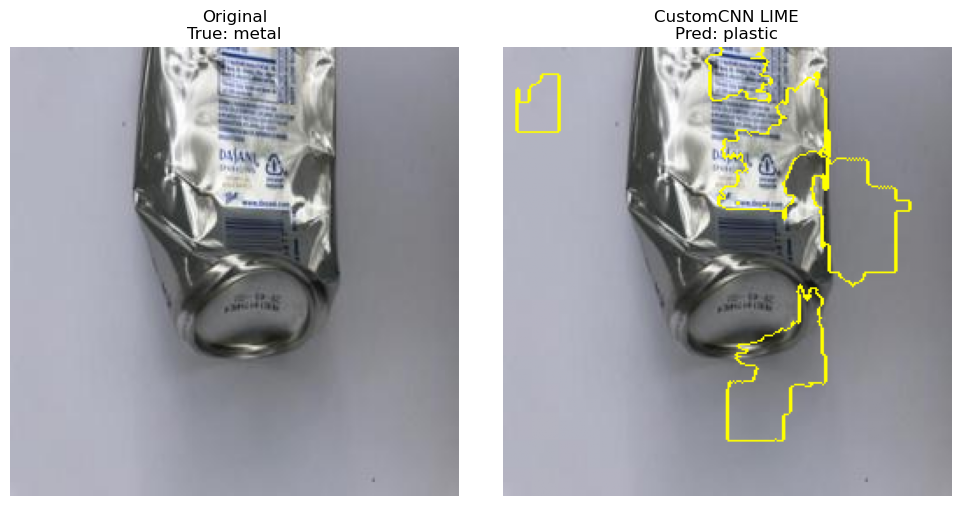

In [17]:
# LIME Explain with Custom CNN
limeExplain(valIDX, cnnLoad(),                         "CustomCNN")


Model: AxNet
Image index in validation set: 0
True label      : metal
Predicted label : metal (conf = 0.9921)



  0%|          | 0/1000 [00:00<?, ?it/s]

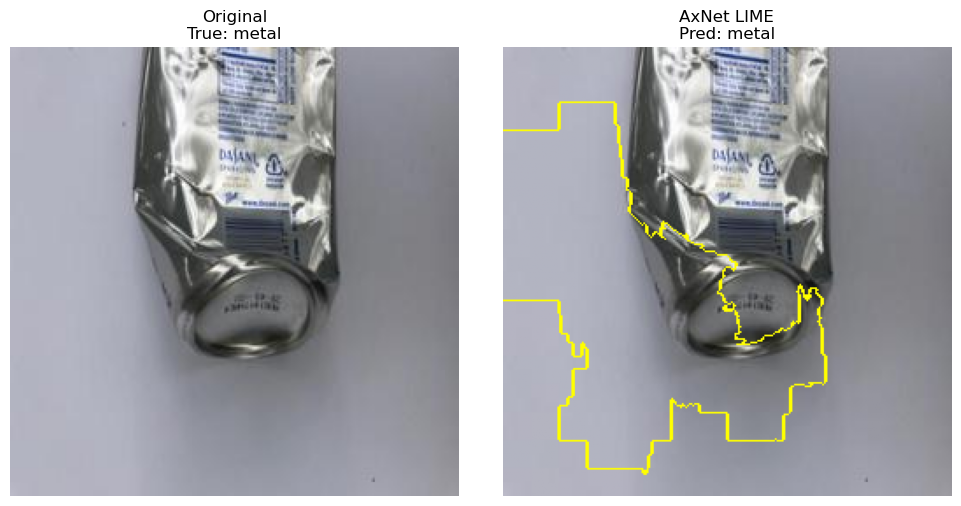

In [18]:
# LIME Explain with AxNet
limeExplain(valIDX, axLoad(),                          "AxNet"    )


Model: Ensemble
Image index in validation set: 0
True label      : metal
Predicted label : metal (conf = 0.8935)



  0%|          | 0/1000 [00:00<?, ?it/s]

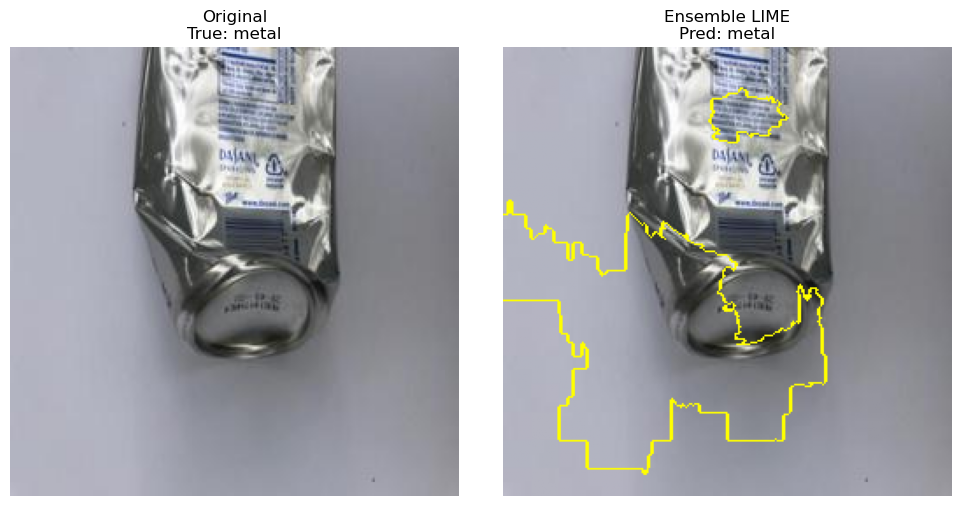

In [19]:
#LIME Explain with Ensemble
limeExplain(valIDX, ensembleLoad(axLoad(), cnnLoad()), "Ensemble" )